# Import needed libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import skew


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.preprocessing import PolynomialFeatures


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFECV, RFE, f_regression


from sklearn.decomposition import PCA

%matplotlib inline

# Load and split the data

In [2]:
user = pd.read_csv("analysis_data.csv", sep=",", index_col="Client")
print(user.shape)

(1566, 41)


In [3]:
user_tr = user[user['Sale_CL']==1]
print(user_tr.shape)

(282, 41)


In [4]:
user_tr = user_tr.drop(['Sale_MF','Sale_CC','Sale_CL','Revenue_MF','Revenue_CC'], axis=1)

In [5]:
user_tr = user_tr.loc[user_tr['Revenue_CL']<133]

In [6]:
user_tr_X = user_tr.drop('Revenue_CL', axis=1)
user_tr_Y = user_tr['Revenue_CL']

## Correlation

In [44]:
for col in user_tr_X.columns:
    print(col)
    print(np.corrcoef(user_tr_Y,user_tr_X[col])[0][1])

Age
0.0630213214537
Tenure
0.0358368076144
M
-0.0573323132822
Count_CA
0.0122996581174
Count_SA
0.00201765805238
Count_MF
-0.00726195406154
Count_OVD
-0.00474483588348
Count_CC
-0.109786977235
Count_CL
0.0932852424331
ActBal_CA
0.0755794257983
ActBal_SA
0.0418647151829
ActBal_MF
0.0802875464949
ActBal_OVD
-0.0173504840843
ActBal_CC
-0.113261118772
ActBal_CL
0.0496885756604
VolumeCred
-0.0325271650945
VolumeCred_CA
-0.0585001393115
TransactionsCred
-0.0351410440883
TransactionsCred_CA
-0.0235844010515
VolumeDeb
-0.014248411518
VolumeDeb_CA
-0.0379950739992
VolumeDebCash_Card
0.0418942465065
VolumeDebCashless_Card
-0.0199465678723
VolumeDeb_PaymentOrder
-0.0635193961608
TransactionsDeb
-0.0704390432902
TransactionsDeb_CA
-0.0629876240609
TransactionsDebCash_Card
-0.00476927644808
TransactionsDebCashless_Card
-0.0820086078967
TransactionsDeb_PaymentOrder
-0.0820349813495
Actbal_CA_avg
0.0784560627796
ActBal_SA_avg
-0.0317740670492
ActBal_MF_avg
0.0831197003859
ActBal_OVD_avg
-0.0173504840

# Preprocessing

## check for skewness and log transform if needed

In [45]:
#log transform skewed numeric features:
user_skew = user_tr_X.drop('M', axis=1)
skewed_feats = user_skew.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

user_tr_X[skewed_feats] = np.log1p(user_tr_X[skewed_feats])

In [46]:
user_tr_Y = np.log1p(user_tr_Y)

## remove outliers

In [28]:
for col in user_tr_X.columns:
    index = user_tr_X[np.abs(user_tr_X[col]-user_tr_X[col].mean())>(4*user_tr_X[col].std())].index.values
    user_tr_X.drop(index, inplace = True)
    user_tr_Y.drop(index, inplace = True)

In [7]:
user_tr_Y.describe()

count    282.000000
mean      11.662752
std        6.961500
min        1.071429
25%        6.267857
50%       10.743036
75%       15.557143
max       46.392857
Name: Revenue_CL, dtype: float64

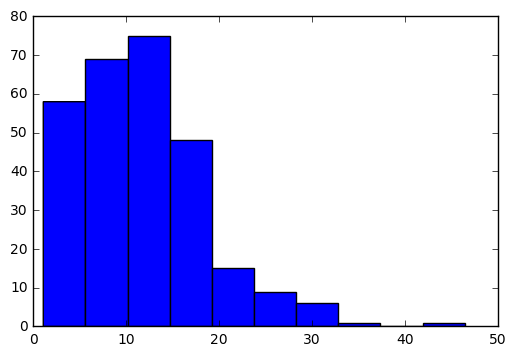

In [8]:
plt.hist(user_tr_Y)
plt.show()

# Check relationship between variables

#scatterplot
sns.set()
cols = user_tr.columns
sns.pairplot(user_tr[cols], x_vars=['Revenue_CL'], size = 2.5)
plt.show();

In [54]:
reg = RandomForestRegressor()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

neg_mean_squared_error: -0.42 (+/- 0.19)
[-0.44408366 -0.35191619 -0.40950035 -0.62754274 -0.4724223  -0.44180856
 -0.22768501 -0.43930905 -0.42844603 -0.4051903 ]


In [10]:
reg = LinearRegression()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores)

neg_mean_squared_error: -60.12 (+/- 28.96)
[-50.77441208 -73.37344393 -50.14923911 -49.93991035 -56.60859673
 -68.25238095 -32.76047685 -79.48510374 -59.01650119 -80.80361265]


In [9]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/home/nico/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/nico/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


roc_auc: -55.56 (+/- 26.89)


In [57]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.39 (+/- 0.21)


## Scaling the params for support vector algo

In [59]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
user_tr_Y_scale = scale(user_tr_Y)

In [65]:
svr = SVR(kernel='linear')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.12 (+/- 0.61)


In [63]:
svr = SVR(kernel='rbf')
scores = cross_val_score(svr,user_tr_X_scale, user_tr_Y_scale, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.13 (+/- 0.54)


## check if improvements with polynomial features

In [66]:
poly = PolynomialFeatures(degree=2)
user_tr_X_pol = poly.fit_transform(user_tr_X)

In [67]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X_pol, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.37 (+/- 0.16)


# Optimization of the algorithm

In [16]:
search = { 'alpha':[0.2, 0.5, 0.7, 1]}


lasso = Lasso(normalize=True)

lasso_grid = GridSearchCV(estimator=lasso,param_grid=search, scoring='neg_mean_squared_error', n_jobs=-1,refit=True, cv=10)

lasso_grid.fit( user_tr_X, user_tr_Y)

print(lasso_grid.best_estimator_)

print(lasso_grid.best_params_)

print(lasso_grid.best_score_)

Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.2}
-48.9352454308


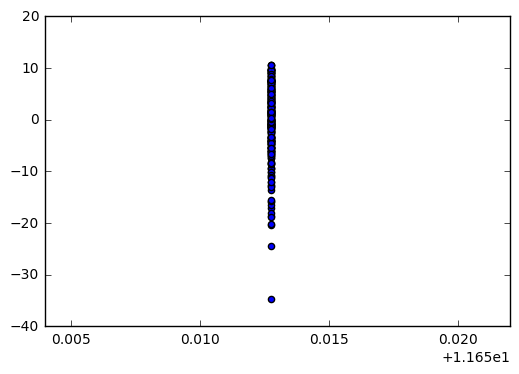

In [17]:
plt.scatter(lasso_grid.predict(user_tr_X), lasso_grid.predict(user_tr_X)-user_tr_Y)

In [103]:
#Scale the 
user_tr_X_scale = scale(user_tr_X)
user_tr_Y_scale = scale(user_tr_Y)

In [13]:
stats.describe(user_tr_Y_scale)

DescribeResult(nobs=287, minmax=(-3.1586085211437931, 3.7911700244708757), mean=-5.5704569876662903e-16, variance=1.0034965034965035, skewness=-0.49206859425252775, kurtosis=0.8201714648150471)

In [52]:
reg = LinearRegression(normalize=True)
reg.fit(X_train,y_train)


y_pred = reg.predict(X_test)
print(mean_absolute_error(y_test, y_pred))


y_pred_train = reg.predict(X_train)
print(mean_absolute_error(y_train, y_pred_train))


0.863004268745
0.432488166754


In [54]:
reg = RandomForestRegressor()
selector = RFECV(estimator=reg, step=1, cv=10,scoring='neg_mean_squared_error')

selector.fit(user_tr_X, user_tr_Y)
user_tr_X_scale_transform = selector.transform(user_tr_X)
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 655


In [39]:
reg = LinearRegression()
scores = cross_val_score(reg, user_tr_X_scale_transform, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -99.57 (+/- 302.68)


reg = SVR(kernel='linear')
selector = RFECV(estimator=reg, step=1, cv=3,scoring='neg_mean_squared_error')

selector.fit(user_tr_X, user_tr_Y)
user_tr_X_scale_transform = selector.transform(user_tr_X_scale)
print("Optimal number of features : %d" % selector.n_features_)


reg = SVR(kernel='rbf')
scores = cross_val_score(reg, user_tr_X_scale_transform, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [55]:
reg = RandomForestRegressor()
scores = cross_val_score(reg, user_tr_X_scale_transform, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.47 (+/- 0.17)


In [18]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.90 (+/- 1.88)


In [19]:
reg = LinearRegression()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.90 (+/- 1.88)


In [20]:
reg = Lasso()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -0.78 (+/- 1.47)


# Try to check the feature importance

In [207]:
#Scale the 

user_tr_X = scale(user_tr_X)
user_tr_Y = scale(user_tr_Y)

In [208]:

# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [209]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(user_tr_X, user_tr_Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

finished


In [210]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(user_tr_X, user_tr_Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(user_tr_X, user_tr_Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 feat

In [211]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(user_tr_X, user_tr_Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(user_tr_X, user_tr_Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(user_tr_X, user_tr_Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

In [212]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(user_tr_X, user_tr_Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [213]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
Age	0.02	0.11	0.86	0.32	0.29	0.0	0.27
Tenure	0.0	0.04	0.78	0.21	0.15	0.0	0.2
M	0.0	0.04	0.1	0.18	0.15	0.0	0.08
Count_CA	0.0	0.07	0.01	0.26	0.06	0.0	0.07
Count_SA	0.0	0.16	0.02	0.5	0.25	0.0	0.16
Count_MF	0.01	0.12	0.21	0.38	0.26	0.0	0.16
Count_OVD	0.0	0.02	0.06	0.09	0.14	0.0	0.05
Count_CC	0.97	0.31	0.04	0.94	0.53	0.0	0.46
Count_CL	0.87	0.28	0.0	0.91	0.67	0.0	0.46
ActBal_CA	0.0	0.8	0.66	0.85	0.03	0.0	0.39
ActBal_SA	1.0	0.58	0.2	0.82	1.0	0.0	0.6
ActBal_MF	0.41	0.2	0.01	0.35	0.36	0.0	0.22
ActBal_OVD	0.0	0.0	0.07	0.12	0.0	0.0	0.03
ActBal_CC	0.34	0.03	0.03	0.24	0.11	0.0	0.12
ActBal_CL	0.0	0.11	0.0	0.41	0.21	0.0	0.12
VolumeCred	0.0	0.09	0.53	0.47	0.05	0.0	0.19
VolumeCred_CA	0.0	0.25	0.6	0.74	0.48	0.0	0.34
TransactionsCred	0.0	0.69	0.28	0.97	0.43	0.0	0.4
TransactionsCred_CA	0.0	0.93	0.25	1.0	0.81	0.0	0.5
VolumeDeb	0.0	0.12	0.35	0.44	0.2	0.0	0.18
VolumeDeb_CA	0.0	0.59	0.37	0.79	0.52	0.0	0.38
VolumeDebCash_Card	0.0	0.01	0.63	0.06	0.08	0.0	0.13
Vol

In [214]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

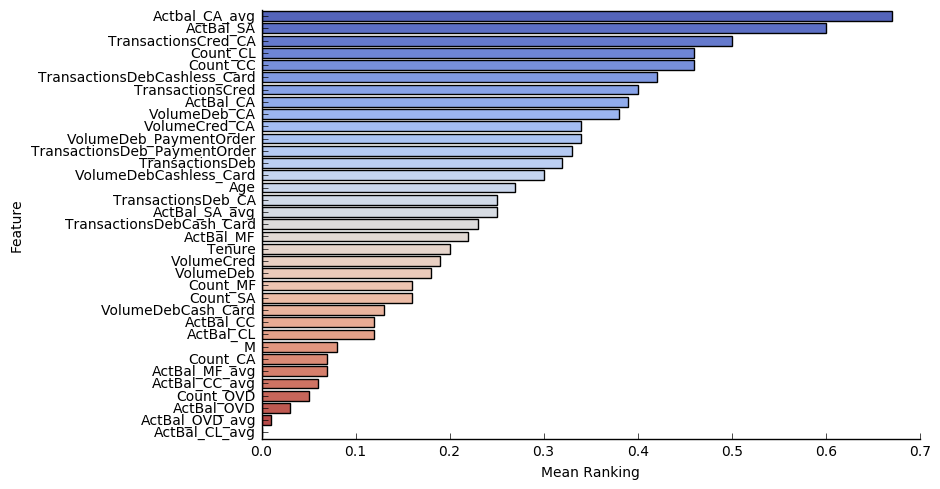

In [215]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=5, aspect=1.9, palette='coolwarm')

In [216]:
user_tr_X = user_tr.drop(['Revenue_CL'], axis=1)


In [217]:
reg = RandomForestRegressor()
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.6f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.298499 (+/- 0.64)


In [218]:
reg = Ridge()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.87 (+/- 3.91)


In [219]:
reg = LinearRegression()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.87 (+/- 3.90)


In [ ]:
reg = Lasso()
scores = cross_val_score(reg,user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

roc_auc: -1.65 (+/- 3.18)


In [ ]:
reg = SVR(kernel='linear')
scores = cross_val_score(reg, user_tr_X, user_tr_Y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("roc_auc: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))